# 1. Setup

In [ ]:
!pip install tensorflow
!pip install matplotlib
!pip install ibm_watson_machine_learning
!pip install seaborn    

In [ ]:
import json

with open('credentials.json') as f:
    data = json.load(f)
    API_KEY = data['API_KEY']
    LOCATION = data['LOCATION']
    PROJECT_ID = data['PROJECT_ID']
    SPACE_ID = data['SPACE_ID']

# 2. Create a model

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
# load mnist data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# normalize data
x_train, x_test = x_train / 255.0, x_test / 255.0
# add a channels dimension
x_train = x_train[..., tf.newaxis] 
x_test = x_test[..., tf.newaxis]
# create a dataset
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)
# create a model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])
# compile
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# train
model.fit(train_ds, epochs=5)
# evaluate
model.evaluate(test_ds)
# save the model
model.save('model.h5')

# 3. Save the model to watson studio 

In [ ]:
from ibm_watson_machine_learning import APIClient

wml_credentials = {
    "apikey": API_KEY,
    "url": LOCATION
}

wml_client = APIClient(wml_credentials)
# Watson Studio project
wml_client.set.default_project(PROJECT_ID)
# Watson Machine Learning space
wml_client.set.default_space(SPACE_ID)

In [ ]:
# get the number of parameters in the model
def get_model_parameters(model):
    return np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
model_number_of_parameters = get_model_parameters(model)

# get the size of the model in megabytes with two decimal places
def get_model_size(model_name):
    import os
    return round(os.path.getsize(model_name + '.tar.gz') / 1000000, 2)
model_size_mb=get_model_size('mnist_model')

In [160]:
model_name='mnist_'+str(model_size_mb) + "MB"+'_'+str(model_number_of_parameters)+'params'

In [ ]:
# create a tar.gz file with the model
def create_tar_gz_file(model_name):
    import tarfile
    import os
    import shutil
    # create a tar.gz file with the model
    tar = tarfile.open(model_name + '.tar.gz', "w:gz")
    tar.add('model.h5')
    tar.close()

create_tar_gz_file(model_name)

In [ ]:
# list of model metadata properties
wml_client.repository.ModelMetaNames.get()

In [162]:

sofware_spec_uid = wml_client.software_specifications.get_id_by_name("runtime-22.2-py3.10")

metadata = {
            wml_client.repository.ModelMetaNames.NAME: model_name,
            wml_client.repository.ModelMetaNames.TYPE: 'tensorflow_2.9',
            wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid,
            wml_client.repository.ModelMetaNames.SIZE: {'size_in_mb':str(model_size_mb) + " MB", 'number_of_parameters':str(model_number_of_parameters)}
}

published_model = wml_client.repository.store_model(
    model=model_name+".tar.gz",
    meta_props=metadata)

In [163]:
import json

published_model_uid = wml_client.repository.get_model_id(published_model)
model_details = wml_client.repository.get_details(published_model_uid)
print(json.dumps(model_details, indent=2))

{
  "entity": {
    "hybrid_pipeline_software_specs": [],
    "size": {},
    "software_spec": {
      "id": "b56101f1-309d-549b-a849-eaa63f77b2fb",
      "name": "runtime-22.2-py3.10"
    },
    "type": "tensorflow_2.9"
  },
  "metadata": {
    "created_at": "2023-01-12T11:37:12.763Z",
    "id": "37ee824c-a1ca-4684-9a93-196caa3b93f4",
    "modified_at": "2023-01-12T11:37:17.966Z",
    "name": "mnist_7.74MB_693962params",
    "owner": "IBMid-6650024HXN",
    "resource_key": "4c09c6a8-4318-4466-825a-35827a22e020",
    "space_id": "78f24148-ba79-4067-ad83-033bf2937545"
  },
  "system": {
    "warnings": []
  }
}


In [167]:
models_details = wml_client.repository.list_models()

------------------------------------  -------------------------  ------------------------  --------------
ID                                    NAME                       CREATED                   TYPE
37ee824c-a1ca-4684-9a93-196caa3b93f4  mnist_7.74MB_693962params  2023-01-12T11:37:12.002Z  tensorflow_2.9
9c10158e-7af0-4dc6-83ab-128c8d35629a  mnist_small_v2             2023-01-12T07:37:04.002Z  tensorflow_2.9
38fba3c6-2c98-486c-9e02-a859e4b24003  mnist_small                2023-01-12T07:36:31.002Z  tensorflow_2.9
6a7b41cb-fa03-49db-aa04-9e4a97bda834  mnist_small                2023-01-12T04:41:43.002Z  tensorflow_2.9
------------------------------------  -------------------------  ------------------------  --------------


### deploy model to watson machine learning

http://ibm-wml-api-pyclient.mybluemix.net/

In [168]:
metadata = {
    wml_client.deployments.ConfigurationMetaNames.NAME: "Deployment of "+model_name,
    wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = wml_client.deployments.create(published_model_uid, meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: '37ee824c-a1ca-4684-9a93-196caa3b93f4' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
..
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='10c8aef2-1447-425b-94d6-0da6ec69b29a'
------------------------------------------------------------------------------------------------




In [169]:
deployment_uid = wml_client.deployments.get_id(created_deployment)
deployment_uid

'10c8aef2-1447-425b-94d6-0da6ec69b29a'

In [170]:
scoring_endpoint = wml_client.deployments.get_scoring_href(created_deployment)
print(scoring_endpoint)

https://us-south.ml.cloud.ibm.com/ml/v4/deployments/10c8aef2-1447-425b-94d6-0da6ec69b29a/predictions


### test deployed model

In [171]:
# prepare one entry from test_ds for prediction
def prepare_prediction(image_vector, label):
    image_vector = tf.cast(image_vector, tf.float32)
    image_vector = image_vector[tf.newaxis, ...]
    return image_vector, label

In [172]:
prepared_input=prepare_prediction(x_test[0], y_test[0])
# do prediction locally
results=model.predict(prepared_input[0],prepared_input[1])
# print results
print("predicted digit: {}".format(np.argmax(results)))

1/1 [==============================] - 0s 29ms/step
predicted digit: 7


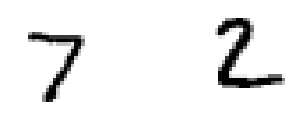

In [173]:
%matplotlib inline
import matplotlib.pyplot as plt

for i, image in enumerate([x_test[0], x_test[1]]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

In [174]:
prepared_input=prepare_prediction(x_test[0], y_test[0])
scoring_payload = {"input_data": [{"values": prepared_input[0].numpy().tolist()}]}
predictions = wml_client.deployments.score(deployment_uid, scoring_payload)

In [187]:
print("predicted digit: {}".format(np.argmax(predictions["predictions"][0]["values"][0][0])))

predicted digit: 7


In [176]:
# TODO: include scripts for data prepocessing + beautifying the predictions into a function and deploy it with the model

In [ ]:
# TODO: figure out how to deploy to different enviroments

### do measurements

In [ ]:
# TODO: create multiple models of different sizes and deploy them + measure the performance

In [203]:
# create a new thread and do a prediction for n images every 2 seconds
import threading
import time
import pandas as pd
import numpy as np

# do a prediction for a single image
def predict_image():
    prepared_input=prepare_prediction(x_test[i], y_test[i])
    scoring_payload = {"input_data": [{"values": prepared_input[0].numpy().tolist()}]}
    wml_client.deployments.score(deployment_uid, scoring_payload)
    
def predict_image(package_number,thread_number):
    start = time.time()
    prepared_input=prepare_prediction(x_test[i], y_test[i])
    scoring_payload = {"input_data": [{"values": prepared_input[0].numpy().tolist()}]}
    wml_client.deployments.score(deployment_uid, scoring_payload)
    end = time.time()
    
    time_elapsed=end - start
    df.at[thread_number, package_number] = time_elapsed


if __name__ == "__main__":
    parallel_requests=5
    number_of_packages=15
    time_between_packages=1

    df = pd.DataFrame(np.zeros((parallel_requests,number_of_packages)))

    for package_number in range(number_of_packages):
        for thread_number in range(parallel_requests):
            thread = threading.Thread(target=predict_image,args=(package_number,thread_number))
            thread.start()
        time.sleep(time_between_packages)
    time.sleep(20)      # waiting a default 10 seconds to make sure all threads finished


In [204]:
# apply a color gradient to the dataframe
def color_dataframe(df):
    def _color_red_or_green(val):
        color = 'black' if val > 10 else 'red' if val >5 else 'darkorange' if val > 1 else 'green'
        return 'background-color: %s' % color
    return df.style.applymap(_color_red_or_green)

color_dataframe(df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.601726,0.939504,1.715683,1.461025,1.194579,1.537310,1.120792,1.179515,1.009030,0.959000,1.122406,0.766666,0.945035,0.918061,1.131057
1,1.474217,1.650308,1.620690,1.580036,1.377100,1.188550,0.800789,0.882513,1.084031,1.166006,0.781885,1.094186,0.970059,0.489996,0.654004
2,1.336201,1.677311,1.114682,1.673034,1.362097,1.295307,0.965789,1.150515,0.683509,1.095006,1.127417,1.056190,1.216061,1.024059,0.932055
3,1.188183,1.197527,1.558691,1.686033,1.173583,1.146544,1.279301,1.054514,1.083026,0.935999,1.051890,0.857662,1.213059,0.498002,1.090053
4,1.450214,1.657295,1.199698,1.708036,1.215581,1.562305,1.282790,1.193513,1.004027,1.151003,1.049888,1.082173,1.236066,1.017057,1.101051
